In [1]:
pip install faiss-cpu pillow tensorflow numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 63.4 MB/s eta 0:00:00


In [2]:
import numpy as np
import faiss
from PIL import Image
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt

# Load pre-trained ResNet50 model
resnet_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

# Load embeddings (ensure these are already saved for CIFAR-10 dataset)
embeddings = np.load("/content/cifar_embeddings.npy")

# Load CIFAR-10 dataset
(cifar_images, _), (_, _) = tf.keras.datasets.cifar10.load_data()

# Normalize embeddings for FAISS
embeddings = embeddings.astype('float32')
faiss.normalize_L2(embeddings)

# Build FAISS index
d = embeddings.shape[1]  # dimension of embeddings
nlist = 100  # number of clusters
quantizer = faiss.IndexFlatL2(d)
index = faiss.IndexIVFFlat(quantizer, d, nlist, faiss.METRIC_INNER_PRODUCT)

# Train the index with embeddings
index.train(embeddings)

# Add CIFAR-10 embeddings to the FAISS index
index.add(embeddings)

# Function to preprocess the query image
def preprocess_image(image_path):
    img = Image.open(image_path).resize((224, 224))  # ResNet50 expects 224x224
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return preprocess_input(img_array)

# Function to get the embedding of the query image
def get_embedding(image_path):
    preprocessed_img = preprocess_image(image_path)
    embedding = resnet_model.predict(preprocessed_img)
    embedding = embedding.flatten().astype('float32')
    faiss.normalize_L2(embedding.reshape(1, -1))  # Normalize for cosine similarity
    return embedding

# Function to find similar images using FAISS
def find_similar_images(query_image_path, k=5):
    query_embedding = get_embedding(query_image_path)

    # Perform the search
    distances, indices = index.search(query_embedding.reshape(1, -1), k)

    return indices[0], distances[0]

# Function to display the query image and similar images
def display_images(query_image_path, similar_indices, similarities):
    # Load and resize query image to match CIFAR-10 size for consistency
    query_img = Image.open(query_image_path).resize((32, 32))

    # Create a figure with subplots
    fig, axs = plt.subplots(1, 6, figsize=(20, 4))
    fig.suptitle("Query Image and Top 5 Similar Images", fontsize=16)

    # Display query image
    axs[0].imshow(query_img)
    axs[0].set_title("Query Image")
    axs[0].axis('off')

    # Display the top 5 similar images from CIFAR-10
    for i, (idx, sim) in enumerate(zip(similar_indices, similarities)):
        similar_img = cifar_images[idx]
        axs[i+1].imshow(similar_img)
        axs[i+1].set_title(f"Sim: {sim:.2f}")
        axs[i+1].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage



94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


(array([ 864, 1883, 4727,   -1,   -1]),
 array([ 3.7771612e-01,  3.5039169e-01,  3.4954664e-01, -3.4028235e+38,
        -3.4028235e+38], dtype=float32))

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Indices of similar images: [ 864 1883 4727   -1   -1]
Similarity scores: [ 3.7771606e-01  3.5039181e-01  3.4954673e-01 -3.4028235e+38
 -3.4028235e+38]


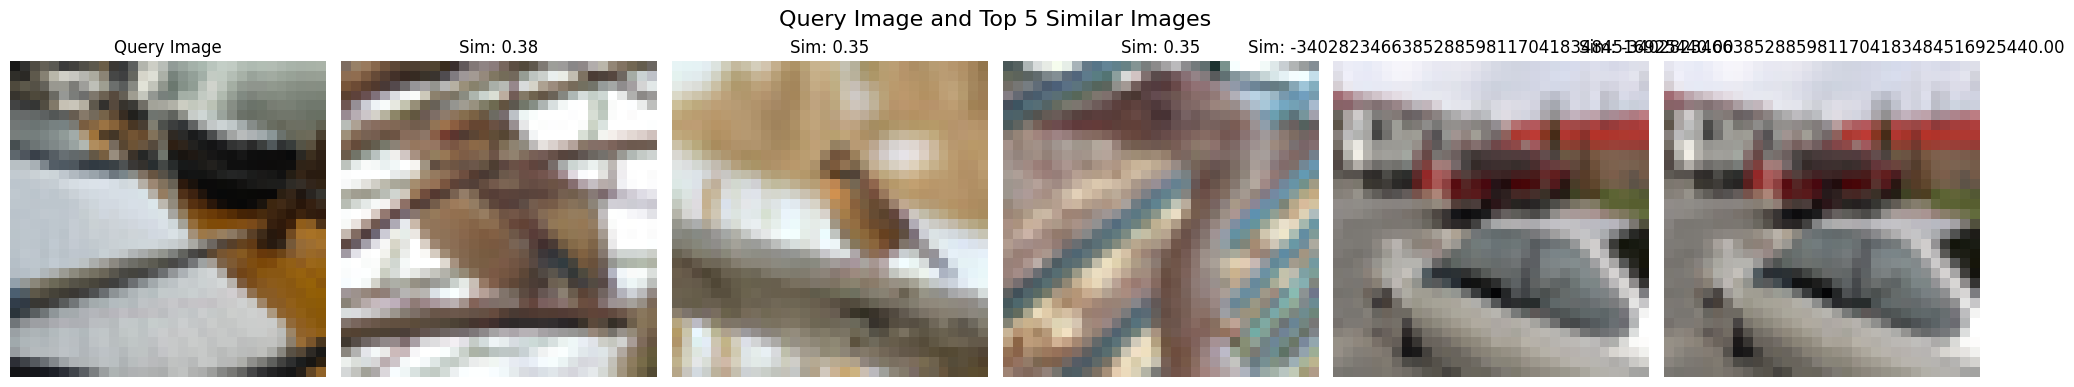

In [4]:
query_image_path = "/content/WhatsApp Image 2024-09-28 at 23.26.55.jpeg"
similar_indices, similarities = find_similar_images(query_image_path)

print("Indices of similar images:", similar_indices)
print("Similarity scores:", similarities)

# Display the query image and similar images
display_images(query_image_path, similar_indices, similarities)